# Preprocessing with Bounding Boxes

In [1]:
import pathlib
import sys

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#import utilities
sys.path.append('src/')
import utils as utils
from preprocessing3 import *


#from effdet.config.model_config import efficientdet_model_param_dict
#from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
#from effdet.efficientdet import HeadNet
#import timm

#import tensorflow as t
#from tensorflow import keras

#from comet_ml import Experiment

In [2]:
# import random

In [3]:
'''
import albumentations as A
from albumentations.pytorch import ToTensor

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
from torch import nn
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam,lr_scheduler

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from tqdm import tqdm_notebook, tqdm
'''

'\nimport albumentations as A\nfrom albumentations.pytorch import ToTensor\n\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\nimport torchvision\nimport torchvision.transforms.functional as TF\nfrom torch import nn\nimport torch.nn.functional as F\nfrom torch.utils.data import SubsetRandomSampler\nfrom torch.utils.data.sampler import SequentialSampler, RandomSampler\nfrom torch.optim import Adam,lr_scheduler\n\nfrom torchvision.models.detection.faster_rcnn import FastRCNNPredictor\n\nfrom tqdm import tqdm_notebook, tqdm\n'

In [4]:
# define training and save paths and read in training csv and label key
data_dir = pathlib.Path('gwhd_2021/images/')
images = list(data_dir.glob('*.jpg'))

In [5]:
# images

In [6]:
# Import data
metadata = pd.read_csv('gwhd_2021/metadata_dataset.csv', sep=';')
train = pd.read_csv('gwhd_2021/competition_train.csv')
# Update metadata['name'] to metadata['domain'] to match full column name
metadata.rename(columns = {"name": "domain"}, inplace=True)

In [7]:
# Merge dfs and preprocess
train_df = train.merge(metadata, on='domain')

In [8]:
test = pd.read_csv('gwhd_2021/competition_test.csv')

In [9]:
test_df = test.merge(metadata, on='domain')

In [10]:
train_df = utils.preprocess_df(train_df)

In [11]:
train_df.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox_width,bbox_height
0,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[99, 692, 160, 764]",Arvalis_1,France,Gréoux,Post-flowering,99.0,692.0,160.0,764.0,61.0,72.0
1,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[641, 27, 697, 115]",Arvalis_1,France,Gréoux,Post-flowering,641.0,27.0,697.0,115.0,56.0,88.0
2,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[935, 978, 1012, 1020]",Arvalis_1,France,Gréoux,Post-flowering,935.0,978.0,1012.0,1020.0,77.0,42.0
3,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[377, 834, 463, 890]",Arvalis_1,France,Gréoux,Post-flowering,377.0,834.0,463.0,890.0,86.0,56.0
4,4563856cc6d75c670eafd86d5eb7245fbe8f273c28f9e3...,"[654, 797, 696, 837]",Arvalis_1,France,Gréoux,Post-flowering,654.0,797.0,696.0,837.0,42.0,40.0


In [12]:
test_df = utils.preprocess_df(test_df)

In [13]:
test_df.head()

,image_name,BoxesString,domain,country,location,development_stage,bbox_xmin,bbox_ymin,bbox_xmax,bbox_ymax,bbox_width,bbox_height
0,255b6ca9fea63f44125e5174bc932470b604c760430715...,"[481, 820, 604, 922]",UQ_7,Australia,Gatton,Ripening,481.0,820.0,604.0,922.0,123.0,102.0
1,255b6ca9fea63f44125e5174bc932470b604c760430715...,"[655, 957, 732, 1024]",UQ_7,Australia,Gatton,Ripening,655.0,957.0,732.0,1024.0,77.0,67.0
2,255b6ca9fea63f44125e5174bc932470b604c760430715...,"[930, 926, 1013, 1024]",UQ_7,Australia,Gatton,Ripening,930.0,926.0,1013.0,1024.0,83.0,98.0
3,255b6ca9fea63f44125e5174bc932470b604c760430715...,"[809, 851, 910, 924]",UQ_7,Australia,Gatton,Ripening,809.0,851.0,910.0,924.0,101.0,73.0
4,255b6ca9fea63f44125e5174bc932470b604c760430715...,"[836, 904, 866, 967]",UQ_7,Australia,Gatton,Ripening,836.0,904.0,866.0,967.0,30.0,63.0


First off, let's address the class imbalances of development stage. 

## Balancing class distribution

In [14]:
#utils.set_plot(16)
#train_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        #legend=False, color='royalblue', 
                                                        #xlabel="Development stage")
#plt.show()

In [15]:
## To use the balanced_df function, we will need a numeric label representation
#label_dict = {'Ripening': 0, 'Post-flowering': 1, 'Filling - Ripening': 2, 'Filling': 3}

#train_df['label'] = train_df['development_stage'].copy()
#train_df['label'].replace(label_dict, inplace=True)

In [16]:
#balanced_df = utils.balance_df(train_df, class_size=10000)

In [17]:
#balanced_df.groupby('development_stage').count().plot.barh(title='Training Images - Class Counts', 
                                                        #legend=False, color='royalblue', 
                                                        #xlabel="Development stage")
#plt.show()

# Test-Time Augmentation with Mosaic Generator
~~Although the augmentations completed in the previous notebook looked great, the process of creating those augmented images (with the albumentations library) is just too computationally expensive to be a viable option for an image dataset of this size. As a more cost-efficient alternative, we will instead use Time-Test Augmentation (TTA) to employ simple, real-time augmentions at the time of modeling using the `ImageDataGenerator` class from Keras. ~~

In [18]:
'''
# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
    # convert image into dataset
    samples = expand_dims(image, 0)
    # prepare iterator
    it = datagen.flow(samples, batch_size=n_examples)
    # make predictions for each augmented image
    yhats = model.predict_generator(it, steps=n_examples, verbose=0)
    # sum across predictions
    summed = numpy.sum(yhats, axis=0)
    # argmax across classes
    return argmax(summed)
'''

'\n# make a prediction using test-time augmentation\ndef tta_prediction(datagen, model, image, n_examples):\n    # convert image into dataset\n    samples = expand_dims(image, 0)\n    # prepare iterator\n    it = datagen.flow(samples, batch_size=n_examples)\n    # make predictions for each augmented image\n    yhats = model.predict_generator(it, steps=n_examples, verbose=0)\n    # sum across predictions\n    summed = numpy.sum(yhats, axis=0)\n    # argmax across classes\n    return argmax(summed)\n'

In [19]:
train_image_ids = train_df.image_name.unique()
test_image_ids = test_df.image_name.unique()

In [20]:
#def collate_fn(batch):
    #return tuple(zip(*batch))

In [21]:
train_dataset = WheatDataset(
    image_ids=train_image_ids,
    labels_df= train_df,
    transforms=get_train_transforms(),
    test=False
)

validation_dataset = WheatDataset(
    image_ids=test_image_ids,
    labels_df=test_df,
    transforms=get_valid_transforms(),
    test=True
)

In [22]:
# Create dataloader
train_loader = DataLoader(train_dataset,
                         batch_size = TrainGlobalConfig.batch_size,
                         collate_fn = collate_fn,
                         shuffle=True)

validation_loader = DataLoader(validation_dataset,
                         batch_size = TrainGlobalConfig.batch_size,
                         collate_fn = collate_fn)

In [ ]:
# Syntax:
# cv2.rectangle(image, start_point, end_point, color, thickness)

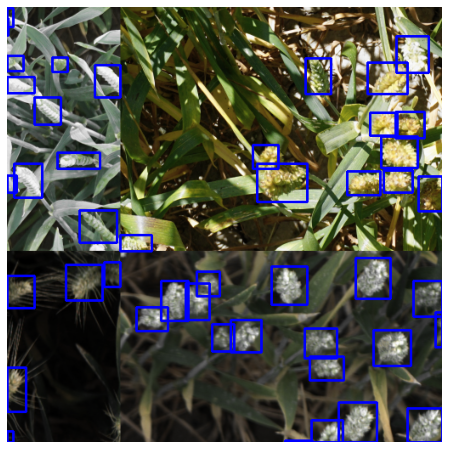

In [23]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    #cv2.rectangle(numpy_image, (box[0], box[1]), (box[2],  box[3]), (0, 1, 0), 1)
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 0, 1), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image)

*Note: To see further implementations of both Albumentations augmentations, as well as CutMix TTA augmentations, please see their respective notebooks contained in this repo.*
* `Data_Augmentation_Albumentations.ipynb`
* `Data_Augmentation_CutMix.ipynb`

## Fitting the model

In [25]:
from effdet.config.model_config import efficientdet_model_param_dict
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
import timm

In [26]:
print('timm currently has {} models available,'.format(len(timm.list_models('*'))))

timm currently has 739 models available,


In [27]:
print(f'timm currently has: {len(timm.list_models(pretrained=True))} pre-trained models available.')

timm currently has: 592 pre-trained models available.


In [28]:
print(f'number of configs for efficientdet: {len(efficientdet_model_param_dict)}')

list(efficientdet_model_param_dict.keys())[::3]

number of configs for efficientdet: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

$\Rightarrow$ $\Rightarrow$ See link to TensorFlow's [effdet d5 here](https://tfhub.dev/tensorflow/efficientdet/d5/1) $\Leftarrow$ $\Leftarrow$

In [29]:
timm.list_models('tf_efficientnetv2_*')

['tf_efficientnetv2_b0',
 'tf_efficientnetv2_b1',
 'tf_efficientnetv2_b2',
 'tf_efficientnetv2_b3',
 'tf_efficientnetv2_l',
 'tf_efficientnetv2_l_in21ft1k',
 'tf_efficientnetv2_l_in21k',
 'tf_efficientnetv2_m',
 'tf_efficientnetv2_m_in21ft1k',
 'tf_efficientnetv2_m_in21k',
 'tf_efficientnetv2_s',
 'tf_efficientnetv2_s_in21ft1k',
 'tf_efficientnetv2_s_in21k',
 'tf_efficientnetv2_xl_in21ft1k',
 'tf_efficientnetv2_xl_in21k']

#### For full list of models available from `timm`: `timm.list_models()`


## Creating the model

In [ ]:
#def get_net():
    #config = get_efficientdet_config('tf_efficientdet_d5')
    #net = EfficientDet(config, pretrained_backbone=False)
    #checkpoint = torch.load('tf_efficientdet_d5_51-c79f9be6.pth')
    #net.load_state_dict(checkpoint)
    #config.num_classes = 1
    #config.image_size = 512
    #net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    #return DetBenchTrain(net, config)

#net = get_net()

In [ ]:
#from effdet import create_model_from_config, get_efficientdet_config

#base_config = get_efficientdet_config('tf_efficientdet_d5')
#base_config.image_size = (512, 512)
#net = create_model_from_config(base_config, bench_task='predict', num_classes=1,
                                  #checkpoint_path='tf_efficientdet_d5_51-c79f9be6.pth')

In [31]:
config = get_efficientdet_config('tf_efficientdet_d5')

config.image_size = [512,512]
config.norm_kwargs=dict(eps=.001, momentum=.01)

net = EfficientDet(config, pretrained_backbone=False)
checkpoint = torch.load('tf_efficientdet_d5_51-c79f9be6.pth')
net.load_state_dict(checkpoint)


net.reset_head(num_classes=1)
net.class_net = HeadNet(config, num_outputs=config.num_classes)

DetBenchTrain(net, config)

DetBenchTrain(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishMe()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (act1): SwishMe()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SwishMe()
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(24,

In [34]:
fitter = Fitter(model=net, device=None, config=TrainGlobalConfig)
fitter.fit(train_loader, validation_loader)

Fitter prepared. Device is None

2022-04-12T23:59:50.390400
LR: 0.0002


TypeError: forward() takes 2 positional arguments but 4 were given

In [ ]:
#config = get_efficientdet_config('tf_efficientdet_d5')
#config.image_size = [512,512]
#config.norm_kwargs=dict(eps=.001, momentum=.01)

#net = create_model_from_config(
    #config, bench_task='predict',
    #checkpoint = '../input/effdetweights2/best-checkpoint-009epoch(1).bin',
    #checkpoint_ema=True, # if you are loading a training checkpoint and want the ema version to be used
    #num_clases=14,
#)

In [ ]:
'''
def create_model(num_classes=1, image_size=512, architecture="tf_efficientnetv2_l"):
    efficientdet_model_param_dict['tf_efficientnetv2_l'] = dict(
        name='tf_efficientnetv2_l',
        backbone_name='tf_efficientnetv2_l',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )
    
    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})
    
    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)
'''

**NOTE: Due to the architecture of EfficientDet, the input image size must be divisible by 128!** (We will continue to use 512 x 512 pixels, as we have been doing thus far).

In [ ]:
'''
def get_net():
    config = get_efficientdet_config('tf_efficientnetv2_l')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('tf_efficientnetv2_l') #d3-d7 ('efficientdet_model' folder) 
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()
'''

In [ ]:
#device = torch.device('cuda:0')
#net.to(device)

In [ ]:
#from pytorch_lightning import LightningDataModule
#from torch.utils.data import DataLoader

In [ ]:
#from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchEval
#from effdet.efficientdet import HeadNet

In [ ]:
#from effdet import DetBenchEval